In [1]:
import os
import sys
import pickle

current_dir =  os.getcwd()
#parent_dir = os.path.dirname(current_dir)
#sys.path.insert(0, parent_dir)

grandparent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, grandparent_dir)


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

In [3]:
def tableInfo(tableName):

    print(tableName.head())
    print(tableName.dtypes)
    print(f'Number of rows: {tableName.shape[0]}')
    print(f'Unique FIPS numbers {tableName['GeoFIPS'].nunique()}')

In [4]:
from cities.utils.data_grabber import DataGrabber
data = DataGrabber()
data.get_features_wide(['transport'])
transport = data.wide

transport = transport.get('transport')
transport

,GeoFIPS,GeoName,D3A,WeightAvgNatWalkInd
0,1001,"Autauga, AL",1.981182,5.483179
1,1003,"Baldwin, AL",2.484343,6.812530
2,1005,"Barbour, AL",1.457892,5.156175
3,1007,"Bibb, AL",1.926318,5.241296
4,1009,"Blount, AL",2.808981,4.674447
...,...,...,...,...
3077,56037,"Sweetwater, WY",0.688244,7.693168
3078,56039,"Teton, WY",0.524244,7.276768
3079,56041,"Uinta, WY",1.008798,6.652280
3080,56043,"Washakie, WY",0.757877,7.429655


In [5]:
spending_transportation = pd.read_csv(f"{grandparent_dir}/data/raw/spending_transportation.csv")

tableInfo(spending_transportation)

   year  GeoFIPS  total_obligated_amount
0  2010       69             110719238.0
1  2010       93              13282813.0
2  2010      111             840055898.0
3  2010      153               1248153.0
4  2010      161              48428565.0
year                        int64
GeoFIPS                     int64
total_obligated_amount    float64
dtype: object
Number of rows: 17063
Unique FIPS numbers 3153


In [6]:
# cleaning total_obligated_amount
# deleteting 0 and 1 values as they are not informative

transportUnwanted = spending_transportation[(pd.isna(spending_transportation['total_obligated_amount']) | 
                                (spending_transportation['total_obligated_amount'] == 1) |
                                (spending_transportation['total_obligated_amount'] == 0))] 
print(f' Number of values to remove: {transportUnwanted.shape[0]}')

exclude_mask = spending_transportation['total_obligated_amount'].isin(transportUnwanted['total_obligated_amount'])
spending_transportation = spending_transportation[~exclude_mask]

assert spending_transportation.isna().sum().sum() == 0, 'Na values detected'

tableInfo(spending_transportation)


 Number of values to remove: 66
   year  GeoFIPS  total_obligated_amount
0  2010       69             110719238.0
1  2010       93              13282813.0
2  2010      111             840055898.0
3  2010      153               1248153.0
4  2010      161              48428565.0
year                        int64
GeoFIPS                     int64
total_obligated_amount    float64
dtype: object
Number of rows: 16997
Unique FIPS numbers 3145


In [63]:
count_short_geofips = spending_transportation[spending_transportation['GeoFIPS'] <= 999]['GeoFIPS'].count()

# Print the count
print(count_short_geofips)

46


In [81]:
# fiprs wrangling
common_fips = np.intersect1d(transport['GeoFIPS'].unique(),
                                spending_transportation['GeoFIPS'].unique())

short_geofips = spending_transportation[spending_transportation['GeoFIPS'].astype(str).str.len().between(1, 3)]
short_geofips_list = short_geofips['GeoFIPS'].tolist()

len(common_fips) # loss of over 1000 FIPS!!!

1853

In [87]:
len(spending_transportation['GeoFIPS'].unique())
len(transport['GeoFIPS'].unique())

3082

In [95]:
transport_only_fips = np.setdiff1d(transport['GeoFIPS'], spending_transportation['GeoFIPS'])


spending_only_fips = np.setdiff1d(spending_transportation['GeoFIPS'], transport['GeoFIPS'])
fips4_to_repeair = [fip for fip in spending_only_fips if fip < 10000]
len(fips4_to_repeair)

904

In [97]:
names_transportation = pd.read_csv(f"{grandparent_dir}/data/raw/spending_transportation_names.csv")

In [99]:
print(names_transportation) 

       GeoFIPS                      GeoNameALT  total_obligated_amount
0           69                   Calaveras, CA            8.892735e+07
1           93                    Hartford, CT            1.100617e+07
2          111        District Of Columbia, DC            8.221807e+08
3          111                  Washington, DC            1.678476e+07
4          153                    Honolulu, HI            1.086916e+06
5          161                         Ada, ID            4.550354e+07
6          220                   Anchorage, AK            8.754062e+06
7          361                      Albany, NY            3.183952e+08
8          413                    Maricopa, AZ            3.882182e+07
9          449                  Washington, RI            1.992000e+04
10         667                  Sacramento, CA            4.564641e+07
11         831                      Denver, CO            1.848000e+08
12        1101                  Montgomery, AL            3.561396e+07
13    

In [49]:
geofips_to_geonamealt = dict(zip(names_transportation['GeoFIPS'], names_transportation['GeoNameALT']))

# Use the map function to add the 'GeoNameALT' column to short_geofips
short_geofips['GeoNameALT'] = short_geofips['GeoFIPS'].map(geofips_to_geonamealt)
short_geofips = short_geofips.rename(columns={'GeoFIPS': 'damagedFIPS'})
short_geofips


/tmp/ipykernel_2020/1446214692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_geofips['GeoNameALT'] = short_geofips['GeoFIPS'].map(geofips_to_geonamealt)


,year,damagedFIPS,total_obligated_amount,GeoNameALT
0,2010,69,110719238.0,"Calaveras, CA"
1,2010,93,13282813.0,"Hartford, CT"
2,2010,111,840055898.0,"Washington, DC"
3,2010,153,1248153.0,"Honolulu, HI"
4,2010,161,48428565.0,"Geneva, AL"
...,...,...,...,...
15900,2012,885,9908697.0,"Montrose, CO"
15901,2012,887,980676.0,"Morgan, CO"
15902,2012,889,615351.0,"Otero, CO"
15903,2012,895,160187.0,"Phillips, CO"


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(short_geofips)

In [41]:
print(transport)

      GeoFIPS         GeoName       D3A  WeightAvgNatWalkInd
0        1001     Autauga, AL  1.981182             5.483179
1        1003     Baldwin, AL  2.484343             6.812530
2        1005     Barbour, AL  1.457892             5.156175
3        1007        Bibb, AL  1.926318             5.241296
4        1009      Blount, AL  2.808981             4.674447
...       ...             ...       ...                  ...
3077    56037  Sweetwater, WY  0.688244             7.693168
3078    56039       Teton, WY  0.524244             7.276768
3079    56041       Uinta, WY  1.008798             6.652280
3080    56043    Washakie, WY  0.757877             7.429655
3081    56045      Weston, WY  0.894710             6.215751

[3082 rows x 4 columns]


In [59]:
short_geofipsmapping_dict = dict(zip(transport['GeoName'], transport['GeoFIPS']))

def find_exact_match(geoname, mapping_dict):
    return mapping_dict.get(geoname)

short_geofips['repairedFIPS'] = short_geofips['GeoNameALT'].apply(lambda x: mapping_dict.get(x))
repaired_geofips = short_geofips[short_geofips['repairedFIPS'].notna()]

assert (repaired_geofips.shape[0] / short_geofips.shape[0]) < 90, 'Less than 0.9 damaged FIPS were successfully repaired'


0.9587443946188341

In [ ]:
repaired_geofips

In [75]:
spending_transportation['GeoFIPS'] = spending_transportation['GeoFIPS'].replace(
    dict(zip(repaired_geofips['damagedFIPS'], repaired_geofips['repairedFIPS']))
)

# Print the updated spending_transportation DataFrame
tableInfo(spending_transportation)
count_short_geofips = spending_transportation[spending_transportation['GeoFIPS'] <= 999]['GeoFIPS'].count()
print(count_short_geofips)
assert count_short_geofips / spending_transportation.shape[0] < 0.05, 'More than 0.05 of FIPS are short and will be deleted!'

   year  GeoFIPS  total_obligated_amount
0  2010     6009             110719238.0
1  2010     9003              13282813.0
3  2010    15003               1248153.0
4  2010     1061              48428565.0
6  2010    36001             339491769.0
year                        int64
GeoFIPS                     int64
total_obligated_amount    float64
dtype: object
Number of rows: 16951
Unique FIPS numbers 2869
0


In [74]:
spending_transportation = spending_transportation[spending_transportation['GeoFIPS'] > 999]


In [ ]:
spending_transportation

In [ ]:
unique_geonameALT_values = set(names_transportation['GeoNameALT'].str.upper().unique())
unique_geoname_values = set(transport['GeoName'].str.upper().unique())


df1_differences = unique_geonameALT_values - unique_geoname_values

# Find values that are in 'geoname' but not in 'GeoNameALT' (df2 differences)
df2_differences = unique_geoname_values - unique_geonameALT_values

# Create a DataFrame with the two columns of differences
df1_differences


In [25]:
diff_df

,GeoNameALT,GeoName
0,"BROOMFIELD, CO","BROOMFIELD, CO"
1,"MAVERICK, TX","MAVERICK, TX"
2,"MILLER, MO","MILLER, MO"
3,"CALVERT, MD","CALVERT, MD"
4,"GUADALUPE, TX","GUADALUPE, TX"
...,...,...
2068,"NICHOLAS, KY","NICHOLAS, KY"
2069,"BOZEMAN, MT","BOZEMAN, MT"
2070,"TELFAIR, GA","TELFAIR, GA"
2071,"ALEXANDRIA CITY, VA","ALEXANDRIA CITY, VA"


In [13]:
from cities.utils.data_grabber import DataGrabber
from cities.utils.cleaning_utils import standardize_and_scale
import numpy as np
import pandas as pd

transport = pd.read_csv(f"{grandparent_dir}/data/raw/smartLocationSmall.csv")

#choosing transport variables
transport = transport[['GeoFIPS', 'D3A', 'WeightAvgNatWalkInd']]



# list of GeoFips with Na values
transportUnwanted = transport[(pd.isna(transport['WeightAvgNatWalkInd']) | 
                                (transport['WeightAvgNatWalkInd'] == 1)) |
                               (transport['D3A'] == 0)|
                               (transport['D3A'] == 1)]





exclude_mask = transport['GeoFIPS'].isin(transportUnwanted['GeoFIPS'])
transport = transport[~exclude_mask]




assert transport.isna().sum().sum() == 0, 'Na values detected'
assert transport['GeoFIPS'].is_unique

# subsetting to common FIPS numbers

common_fips = np.intersect1d(gdp['GeoFIPS'].unique(),
                                transport['GeoFIPS'].unique())
transport = transport[transport['GeoFIPS'].isin(common_fips)]

assert len(common_fips) == len(transport['GeoFIPS'].unique())
assert len(transport) > 3000, 'The number of records is lower than 3000'

# adding geoname column
transport = transport.merge(gdp[['GeoFIPS', 'GeoName']],
                        on='GeoFIPS', how='left')[['GeoFIPS',
                                                    'GeoName',
                                                    'D3A',
                                                    'WeightAvgNatWalkInd']]

patState = r', [A-Z]{2}(\*{1,2})?$'
GeoNameError = 'Wrong GeoName value!'
assert transport['GeoName'].str.contains(patState, regex=True).all(), GeoNameError
assert sum(transport['GeoName'].str.count(', ')) == transport.shape[0], GeoNameError


transport_wide = transport.copy()
transport_std_wide = standardize_and_scale(transport)

transport_long = pd.melt(transport, id_vars=['GeoFIPS', 'GeoName'],
                    var_name='Category', value_name='Value')
transport_std_long = pd.melt(transport_std_wide.copy(),  id_vars=['GeoFIPS', 'GeoName'],
                    var_name='Category', value_name='Value')

std_error= 'Standarization error'
assert (transport_std_wide['D3A'] >= -1).all() and (transport_std_wide['D3A'] <= 1).all(), std_error
assert (transport_std_long['Value'] >= -1).all() and (transport_std_long['Value'] <= 1).all(), std_error

transport.dtypes

/tmp/ipykernel_844/1245147264.py:50: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  assert transport['GeoName'].str.contains(patState, regex=True).all(), GeoNameError


GeoFIPS                  int64
GeoName                 object
D3A                    float64
WeightAvgNatWalkInd    float64
dtype: object

In [10]:
transport_std_long

,GeoFIPS,GeoName,Category,Value
0,1001,"Autauga, AL",D3A,-0.269999
1,1003,"Baldwin, AL",D3A,-0.083196
2,1005,"Barbour, AL",D3A,-0.464273
3,1007,"Bibb, AL",D3A,-0.290367
4,1009,"Blount, AL",D3A,0.003045
...,...,...,...,...
6105,56037,"Sweetwater, WY",WeightAvgNatWalkInd,0.131513
6106,56039,"Teton, WY",WeightAvgNatWalkInd,0.087874
6107,56041,"Uinta, WY",WeightAvgNatWalkInd,0.022428
6108,56043,"Washakie, WY",WeightAvgNatWalkInd,0.103897


In [39]:
# from pickle

import pickle

with open(f"{grandparent_dir}/data/raw/exclusions.pkl", 'rb') as file:
    exclusions = pickle.load(file)
exclusions


{'transport': array([15901, 51901, 51903, 51907, 51911, 51913, 51918, 51919, 51921,
        51923, 51929, 51931, 51933, 51939, 51941, 51942, 51944, 51945,
        51947, 51949, 51951, 51953, 51955, 51958], dtype=int64)}

In [48]:
common_fips = np.intersect1d(transport['GeoFIPS'].unique(), gdp['GeoFIPS'].unique())
filtered_roadDens = transport[transport['GeoFIPS'].isin(common_fips)]
filtered_roadDens.reset_index()

print(filtered_roadDens.shape[0])
print(gdp.shape[0])

3082
3106


In [53]:
common_fips2 = np.intersect1d(filtered_transport['GeoFIPS'].unique(), common_fips)

common_fips2

array([], dtype=int64)

In [78]:
# for gdp

common_fips = np.intersect1d(gdp['GeoFIPS'].unique(), transport['GeoFIPS'].unique())
gdp = gdp[gdp['GeoFIPS'].isin(common_fips)]


In [104]:
# for transport

common_fips = np.intersect1d(gdp['GeoFIPS'].unique(), transport['GeoFIPS'].unique())
transport = transport[transport['GeoFIPS'].isin(common_fips)]


In [ ]:
# exclusions

# dict
# values that are in gdp but not transport

common_fips = np.intersect1d(gdp['GeoFIPS'].unique(), transport['GeoFIPS'].unique())
gdp_only_fips = np.setdiff1d(gdp['GeoFIPS'].unique(), common_fips)

exclusions = {'transport': gdp_only_fips}

import pickle

file_path = (f"{grandparent_dir}/data/raw/exclusions.pkl")

with open(file_path, 'wb') as file:
    pickle.dump(exclusions, file)
    
gdp = gdp[~gdp['GeoFIPS'].isin(exclusions.get('transport'))]

{'population': 4}

In [3]:
cainc30 =  pd.read_csv(f"{grandparent_dir}/data/raw/CAINC30_1969_2021.csv", encoding='ISO-8859-1')   

/tmp/ipykernel_14103/2761856790.py:1: DtypeWarning: Columns (2,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  cainc30 =  pd.read_csv(f"{grandparent_dir}/data/raw/CAINC30_1969_2021.csv", encoding='ISO-8859-1')


In [33]:

cainc30 =  pd.read_csv(f"{grandparent_dir}/data/raw/CAINC30_1969_2021.csv", encoding='ISO-8859-1')

population = cainc30[cainc30['Description'] == ' Population (persons) 3/'].copy()

population['GeoFIPS'] = population['GeoFIPS'].fillna('').astype(str)
population['GeoFIPS'] = population['GeoFIPS'].str.strip(' "').astype(int)

population = population[population['GeoFIPS'] % 1000 != 0]

common_fips = np.intersect1d(population['GeoFIPS'].unique(), gdp['GeoFIPS'].unique())
assert len(common_fips) == len(gdp['GeoFIPS'].unique())




/tmp/ipykernel_3303/4256578965.py:1: DtypeWarning: Columns (2,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  cainc30 =  pd.read_csv(f"{grandparent_dir}/data/raw/CAINC30_1969_2021.csv", encoding='ISO-8859-1')


In [34]:
# Create a boolean mask to identify FIPS not in common_fips
fips_not_in_common = population['GeoFIPS'].isin(common_fips) == False

# Filter the 'population' DataFrame to get the FIPS not in common_fips
fips_not_in_common_df = population[fips_not_in_common]

fips_not_in_common_df


#TODO_NIKODEM add to exclusions

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
2177,2010,"Aleutian Islands Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA)
2363,2063,"Chugach Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),7073,6941
2394,2066,"Copper River Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),2616,2630
2549,2105,"Hoonah-Angoon Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,2154,2175,2178,2235,2245,2288,2314,2342,2361,2332
2890,2195,"Petersburg Borough, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,3911,3321,3299,3304,3325,3358,3339,3389,3401,3356
2921,2198,"Prince of Wales-Hyder Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,5709,6298,6272,6274,6244,6125,6018,5825,5725,5729
2952,2201,"Prince of Wales-Outer Ketchikan Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA)
3014,2230,"Skagway Municipality, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,1009,1041,1076,1118,1167,1215,1220,1248,1239,1132
3045,2231,"Skagway-Yakutat-Angoon Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA)
3076,2232,"Skagway-Hoonah-Angoon Census Area, AK*",8,CAINC30,100.0,...,Population (persons) 3/,Number of persons,(NA),(NA),...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA)


In [5]:

order = gdp['GeoFIPS'].tolist()
population = population.set_index('GeoFIPS').reindex(order).reset_index()

# align with gdp
assert population['GeoFIPS'].tolist() == gdp['GeoFIPS'].tolist()
assert population['GeoName'].is_unique

population = population.drop(population.columns[2:8], axis=1) 
assert population.shape[0] == gdp.shape[0]

In [5]:
# 243 NAs prior to 1993
#na_counts = (population == '(NA)').sum().sum()
#print(na_counts)

In [6]:
population.replace('(NA)', np.nan, inplace=True)
population.replace('(NM)', np.nan, inplace=True)

# removed years prior to 1993, missigness, long time ago
population = population.drop(population.columns[2:26], axis=1) 

display(population.head())

assert  population.isna().sum().sum() == 0
assert population.shape[0] == gdp.shape[0]


,GeoFIPS,GeoName,1993,1994,1995,1996,1997,1998,1999,2000,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",36953,38186,39112,40207,41238,42106,42963,44021,...,55558,55594,56034,56278,56954,57371,57728,58245,58877,59095
1,1003,"Baldwin, AL",111416,116565,120896,125412,130164,134444,137555,141342,...,190941,196067,200759,204925,210004,215365,221132,227079,233140,239294
2,1005,"Barbour, AL",27371,27751,27854,28298,28415,28841,28866,29015,...,27320,27158,27043,26633,26217,25608,25380,25205,25180,24964
3,1007,"Bibb, AL",17757,18053,18507,18885,19388,19851,20560,19913,...,22682,22544,22586,22607,22654,22606,22383,22405,22223,22477
4,1009,"Blount, AL",41866,42520,44060,45344,47055,48824,50237,51107,...,57857,58024,58048,58168,58238,58676,58765,58956,59081,59041


In [7]:
for column in population.columns[2:]:
        population[column] = population[column].astype(float)

assert population.shape[0] == gdp.shape[0]

3103


In [72]:
from cities.utils.cleaning_utils import standardize_and_scale


In [ ]:

population_long = pd.melt(population.copy(),  id_vars=['GeoFIPS', 'GeoName'],
    var_name='Year',
    value_name='Value')

population_std_wide = standardize_and_scale(population)
population_std_long = pd.melt(population_std_wide.copy(),  id_vars=['GeoFIPS', 'GeoName'],
                var_name='Year', 
                value_name='Value')

population.to_csv("data/processed/population_wide.csv", index=False)
population_long.to_csv("data/processed/population_long.csv", index=False)
population_std_wide.to_csv("data/processed/population_std_wide.csv", index=False)
population_std_long.to_csv("data/processed/population_std_long.csv", index=False)


In [29]:

from cities.utils.cleaning_utils import standardize_and_scale

gdp = pd.read_csv(f"{grandparent_dir}/data/raw/CAGDP1_2001_2021.csv", encoding='ISO-8859-1')


gdp = gdp.loc[:9533] #drop notes at the bottom

gdp['GeoFIPS'] = gdp['GeoFIPS'].fillna('').astype(str)
gdp['GeoFIPS'] = gdp['GeoFIPS'].str.strip(' "').astype(int)


#remove large regions
gdp = gdp[gdp['GeoFIPS'] % 1000 != 0]

# focus on chain-type GDP
mask = gdp['Description'].str.startswith('Chain')
gdp = gdp[mask]

#drop Region number, Tablename, LineCode, IndustryClassification columns (the last one is empty anyway)
gdp = gdp.drop(gdp.columns[2:8], axis=1) 

#2012 makes no sense, it's 100 throughout
gdp = gdp.drop('2012', axis=1)

gdp.replace('(NA)', np.nan, inplace=True)
gdp.replace('(NM)', np.nan, inplace=True)


#nan_rows = gdp[gdp.isna().any(axis=1)] #  if inspection is needed

gdp.dropna(axis=0, inplace=True)

for column in gdp.columns[2:]:
    gdp[column] = gdp[column].astype(float)


assert gdp['GeoName'].is_unique


# subsetting GeoFIPS to values that transport uses

with open(f"{grandparent_dir}/data/raw/exclusions.pkl", 'rb') as file:
    exclusions = pickle.load(file)

gdp = gdp[~gdp['GeoFIPS'].isin(exclusions.get('transport'))]
assert len(gdp) == len(gdp['GeoFIPS'].unique())
assert len(gdp) > 2800, 'The number of records is lower than 3000'

patState = r', [A-Z]{2}(\*{1,2})?$'
GeoNameError = 'Wrong Geoname value!'
assert gdp['GeoName'].str.contains(patState, regex=True).all(), GeoNameError
assert sum(gdp['GeoName'].str.count(', ')) == gdp.shape[0], GeoNameError

for column in gdp.columns[2:]:
    assert (gdp[column] > 0).all(), f"Negative values in {column}"
    assert (gdp[column].isna().sum() == 0), f"Missing values in {column}"
    assert (gdp[column].isnull().sum() == 0), f"Null values in {column}"
    assert (gdp[column] < 3000).all(), f"Values suspiciously large in {column}"

#TODO_Nikodem investigate strange large values

# adjusting data type int/objcect/float/...


gdp_wide = gdp.copy()
gdp_long = pd.melt(gdp.copy(),  id_vars=['GeoFIPS', 'GeoName'],
var_name='Year',
value_name='Value')

# gdp_long.iloc[:, 2:] = gdp_long.iloc[:, 2:].astype(float)


gdp_std_wide = standardize_and_scale(gdp)
gdp_std_long = pd.melt(gdp_std_wide.copy(),  id_vars=['GeoFIPS', 'GeoName'],
                var_name='Year', 
                value_name='Value')



gdp_std_long.dtypes


/tmp/ipykernel_3303/814755821.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  assert gdp['GeoName'].str.contains(patState, regex=True).all(), GeoNameError


GeoFIPS      int64
GeoName     object
Year        object
Value      float64
dtype: object

In [52]:
gdpTEST = pd.read_csv(f"{grandparent_dir}/data/processed/gdp_std_long.csv", encoding='ISO-8859-1')

gdpTEST.dtypes

GeoFIPS      int64
GeoName     object
Year         int64
Value      float64
dtype: object

In [65]:
gdpTEST


,GeoFIPS,GeoName,Year,Value
0,1001,"Autauga, AL",2001,-0.328672
1,1003,"Baldwin, AL",2001,-0.152298
2,1005,"Barbour, AL",2001,0.107946
3,1007,"Bibb, AL",2001,-0.069359
4,1009,"Blount, AL",2001,0.023777
...,...,...,...,...
62115,56037,"Sweetwater, WY",2021,-0.484441
62116,56039,"Teton, WY",2021,0.039865
62117,56041,"Uinta, WY",2021,-0.468633
62118,56043,"Washakie, WY",2021,-0.265671


In [43]:
gdpTEST.iloc[:, 2:] = gdpTEST.iloc[:, 2:].astype(float)

gdpTEST.dtypes

GeoFIPS      int64
GeoName     object
Year       float64
Value      float64
dtype: object

In [35]:
data_type_error = 'Wrong data type!'
assert gdpTEST.iloc[:, 0].dtype == int, data_type_error
assert gdpTEST.iloc[:, 1].dtype == object, data_type_error
for column in gdpTEST.columns[2:]:
    assert gdpTEST[column].dtype == float, f"The column '{column}' is not of float type."

In [ ]:
year_columns = list(range(2001,2022))
strings_list = [str(x) for x in year_columns]

max_gdp_values = gdp[strings_list].max()

print(max_gdp_values)

In [19]:
features = ["gdp", "population", "transport"]

data = DataGrabber()

data.get_features_wide(features)
# data.get_features_std_wide(features)
# data.get_features_long(features)
# data.get_features_std_long(features)

data.wide[features[1]].iloc[:, 5].dtype


dtype('float64')

In [28]:
cainc30 =  pd.read_csv("../data/raw/CAINC30_1969_2021.csv", encoding='ISO-8859-1')

population = cainc30[cainc30['Description'] == ' Population (persons) 3/'].copy()

population['GeoFIPS'] = population['GeoFIPS'].fillna('').astype(str)
population['GeoFIPS'] = population['GeoFIPS'].str.strip(' "').astype(int)

population = population[population['GeoFIPS'] % 1000 != 0]

common_fips = np.intersect1d(population['GeoFIPS'].unique(), gdp['GeoFIPS'].unique())
assert len(common_fips) == len(gdp['GeoFIPS'].unique())

population = population[population['GeoFIPS'].isin(common_fips)]
assert population.shape[0] == gdp.shape[0]

order = gdp['GeoFIPS'].tolist()
population = population.set_index('GeoFIPS').reindex(order).reset_index()

# align with gdp
assert population['GeoFIPS'].tolist() == gdp['GeoFIPS'].tolist()
assert population['GeoName'].is_unique

GeoFIPS       int64
GeoName      object
Category     object
Value       float64
dtype: object

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = gdp

standard_scaler = StandardScaler()

new_data = pd.DataFrame()
for column in data.columns:
    if data.dtypes[column] == 'float64':
        new = data[column].reshape(-1, 1)
        new = standard_scaler.fit_transform(new)
        min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
        new = min_max_scaler.fit_transform(new)
        new_data[column] = new.reshape(-1)
        



AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
data = gdp

column  = '2021'

demeaned = data[column] - data[column].mean() 
standardized = demeaned / data[column].std()
scaled = ((standardized - standardized.mean()) / (standardized.max() - standardized.min())) * 2


print(
   scaled.mean(), scaled.min(), scaled.max()
)


-5.769265473855961e-19 -0.13601727693960877 1.8639827230603911


In [ ]:

new_data = pd.DataFrame()
for column in data.columns:
    if data[column].dtype == 'float64':
        transformed = (2 * (data[column] - data[column].mean()) / data[column].std()) - 1
        print(column, "mean", transformed.mean())
        new_data[column] = transformed
       
        new_data[column] = (2 * (new_data[column] - new_data[column].min()) / 
        (new_data[column].max() - new_data[column].min()) - 1)
        assert (new_data[column] >= -1).all(), f"Values too small in {column}"
        #assert (new_data[column] < 1).all(), f"Values too large in {column}"
        #assert (new_data[column].mean() < 0.1), f"Mean too large in {column}"
        #assert (new_data[column].mean() > -0.1), f"Mean too small in {column}"



gdp.dtypes
#scaler.fit(your_data)

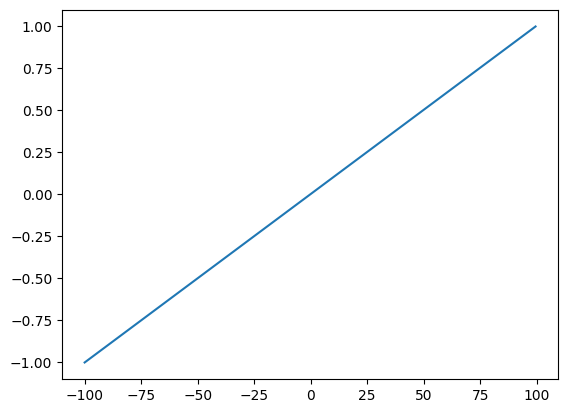

In [ ]:
sequence = np.arange(-100.0, 100, 0.5)
new_sequence = (2 * (sequence - sequence.min()) / 
        (sequence.max() - sequence.min()) - 1)

plt.plot(sequence, new_sequence)
plt.show()


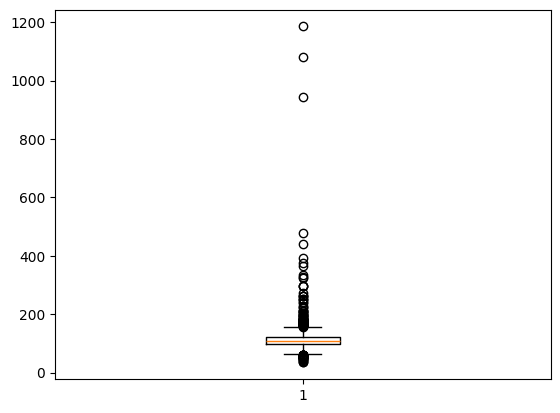

In [22]:
plt.boxplot(x = gdp['2021'])
plt.show()